In [1]:
import uuid, sys, os
import requests
import random
import pandas as pd
import math
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats

from transformers import EsmModel, AutoTokenizer # huggingface
import esm

import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
torch.manual_seed(0)
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
from accelerate import Accelerator
import training_utils.partitioning_utils as pat_utils
from torch.utils.checkpoint import checkpoint

# LoRA
from peft import LoraConfig, get_peft_model

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


NVIDIA A100-PCIE-40GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
print("PyTorch:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.9.1+cu128
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [3]:
# requests.get("https://api.wandb.ai/status").status_code

# import wandb
# wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

In [4]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 0):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing

seq_embed_dimension = 1280 #| 960 | 1152
# struct_embed_dimension = 256
number_of_recycles = 2
padding_value = -5000

In [6]:
# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  42.405855232
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


In [7]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

In [8]:
Df_train = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train_w_pbd_lens.csv",index_col=0).reset_index(drop=True)
Df_test = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test_w_pbd_lens.csv",index_col=0).reset_index(drop=True)

Df_train["target_chain"] = [str(row.ID1[:5]+row.ID1[-1]) for __, row in Df_train.iterrows()]
Df_train["binder_chain"] = [str(row.ID2[:5]+row.ID2[-1]) for __, row in Df_train.iterrows()]

Df_test["target_chain"] = [str(row.ID1[:5]+row.ID1[-1]) for __, row in Df_test.iterrows()]
Df_test["binder_chain"] = [str(row.ID2[:5]+row.ID2[-1]) for __, row in Df_test.iterrows()]

Df_train

,interface_id,PDB,ID1,ID2,seq_target,seq_target_len,seq_pdb_target,pdb_target_len,target_chain,seq_binder,seq_binder_len,seq_pdb_binder,pdb_binder_len,binder_chain,pdb_path
0,6IDB_0,6IDB,6IDB_0_A,6IDB_0_B,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317,6IDB_A,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,172,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,172,6IDB_B,6idb.pdb.gz
1,2WZP_3,2WZP,2WZP_3_D,2WZP_3_G,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122,2WZP_D,TIKNFTFFSPNSTEFPVGSNNDGKLYMMLTGMDYRTIRRKDWSSPL...,266,TIKNFTFFSPNSTEFPVGSNNDGKLYMMLTGMDYRTIRRKDWSSPL...,266,2WZP_G,2wzp.pdb.gz
2,1ZKP_0,1ZKP,1ZKP_0_A,1ZKP_0_C,LYFQSNAKTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLA...,246,LYFQSNAMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGV...,251,1ZKP_A,AKTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLAQLQKYI...,240,AMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLAQLQK...,245,1ZKP_C,1zkp.pdb.gz
3,6GRH_3,6GRH,6GRH_3_C,6GRH_3_D,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266,6GRH_C,MINVYSNLMSAWPATMAMSPKLNRNMPTFSQIWDYERITPASAAGE...,396,MINVYSNLMSAWPATMAMSPKLNRNMPTFSQIWDYERITPASAAGE...,396,6GRH_D,6grh.pdb.gz
4,8R57_1,8R57,8R57_1_M,8R57_1_f,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118,8R57_M,PKKQKHKHKKVKLAVLQFYKVDDATGKVTRLRKECPNADCGAGTFM...,64,PKKQKHKHKKVKLAVLQFYKVDDATGKVTRLRKECPNADCGAGTFM...,64,8R57_f,8r57.pdb.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,4YO8_0,4YO8,4YO8_0_A,4YO8_0_B,HENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNVFHKG...,238,HENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNVFHKG...,238,4YO8_A,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242,4YO8_B,4yo8.pdb.gz
1973,3CKI_0,3CKI,3CKI_0_A,3CKI_0_B,DPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRN...,256,DPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRN...,256,3CKI_A,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121,3CKI_B,3cki.pdb.gz
1974,7MHY_1,7MHY,7MHY_1_M,7MHY_1_N,QVQLRQSGAELAKPGASVKMSCKASGYTFTNYWLHWIKQRPGQGLE...,118,QVQLRQSGAELAKPGASVKMSCKASGYTFTNYWLHWIKQRPGQGLE...,118,7MHY_M,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109,7MHY_N,7mhy.pdb.gz
1975,7MHY_2,7MHY,7MHY_2_O,7MHY_2_P,IQLVQSGPELVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINT...,100,IQLVQSGPELVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINT...,100,7MHY_O,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94,7MHY_P,7mhy.pdb.gz


In [9]:
Df_train[Df_train.ID1.str.startswith("3HU6")].seq_target.item()

'SKVVKFSYMWTINNFSFCREEMGEVIKSSTFSSKLKWCLRVNPKGLDSKDYLSLYLLLVSCPKEVRAKFKFSILNAKGEETKAMESQRAYRFVQGKDWGFKKFIRRGFLLDEANGLLPDDKLTLFCEVSVVQDSQTMNMVKVPECRLADELGGLWENSRFTDCCLCVAGQEFQAHKAILAARSPVFSAMFEHKNRVEINDVEPEVFKEMMCFIYTGKAPNLDKMADDLLAAADKYALERLKVMCEDALCSNLSVENAAEILILADLHSADQLKTQAVDFINYHA'

In [10]:
train_Df1 = Df_train[["target_chain", "seq_pdb_target", "pdb_target_len"]].rename(columns = {
    "seq_pdb_target" : "sequence",
    "target_chain" : "ID",
    "pdb_target_len": "seq_len",
})

train_Df2 = Df_train[["binder_chain", "seq_pdb_binder", "pdb_binder_len"]].rename(columns = {
    "seq_pdb_binder" : "sequence",
    "binder_chain" : "ID",
    "pdb_binder_len": "seq_len",
})

Df_train_LONG = pd.concat([train_Df1, train_Df2], axis=0, ignore_index=True).drop_duplicates(subset="ID", keep="first")
Df_train_LONG

,ID,sequence,seq_len
0,6IDB_A,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317
1,2WZP_D,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122
2,1ZKP_A,LYFQSNAMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGV...,251
3,6GRH_C,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266
4,8R57_M,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118
...,...,...,...
3949,4YO8_B,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242
3950,3CKI_B,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121
3951,7MHY_N,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109
3952,7MHY_P,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94


In [11]:
test_Df1 = Df_test[["target_chain", "seq_pdb_target", "pdb_target_len"]].rename(columns = {
    "seq_pdb_target" : "sequence",
    "target_chain" : "ID",
    "pdb_target_len": "seq_len",
})

test_Df2 = Df_test[["binder_chain", "seq_pdb_binder", "pdb_binder_len"]].rename(columns = {
    "seq_pdb_binder" : "sequence",
    "binder_chain" : "ID",
    "pdb_binder_len": "seq_len",
})

Df_test_LONG = pd.concat([test_Df1, test_Df2], axis=0, ignore_index=True).drop_duplicates(subset="ID", keep="first")
Df_test_LONG

,ID,sequence,seq_len
0,1NNW_A,VYVAVLANIAGNLPALTAALSRIEEMREEGYEIEKYYILGNIVGLF...,251
1,3UCN_A,TADLSPLLEANRKWADECAAKDSTYFSKVAGSQAPEYLYIGCADSR...,222
2,1POV_1,QHRSRSESSIESFFARGACVTIMTVDNPASTTNKDKLFAVWKITYK...,235
3,3R6Y_C,VRIEKDFLGEKEIPKDAYYGVQTIRATENFPITGYRIHPELIKSLG...,383
4,5YHI_A,PMRYPVDVYTGKIQVDGELMLTELGLEGDGPDRALCHYPREHYLYW...,202
...,...,...,...
983,3GXE_F,GLPGMKGHRGF,11
984,6LY5_l,ANFIKPYNDDPFVGHLATPITSSAVTRSLLKNLPAYRFGLTPLLRG...,144
985,5MLK_B,ARISKVLVANRGEIAVRVIRAARDAGLPSVAVYAEPDAESPHVRLA...,384
986,8BS4_B,GHPVLEKLKAAHSYNPKEFEWNLKSGRVFIIKSYSEDDIHRSIKYS...,193


### Loading seqeunce, structural_embeddings & using pooled embeddings for CLIP

In [12]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.max_len = self.dframe["seq_len"].max()

        # paths
        self.seq_encodings_path, self.struct_encodings_path = paths

        # index & storage
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):

            # laod embeddings
            emb_struct = np.load(os.path.join(self.struct_encodings_path, f"{accession}.npy"))     # [Lb, D]
            sequence = self.dframe.loc[accession].sequence

            if len(sequence) != emb_struct.shape[0]:
                print(sequence, emb_struct.shape[0])

            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            if emb_struct.shape[0] < self.max_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.max_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.max_len] # no padding was used

            self.samples.append((sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sequence, emb_struct = self.samples[idx]
        emb_struct = torch.from_numpy(emb_struct).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe        
        return sequence, emb_struct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        sequence_list, emb_struct_list, lbl_list = zip(*out)
    
        # Stack embeddings    
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        lbl_stacked = torch.stack(lbl_list)  # [B]
    
        return list(sequence_list), emb_struct_stacked, lbl_stacked

emb_seq_path = "/work3/s232958/data/PPint_DB/embeddings_esm2"
emb_struct_path = "/work3/s232958/data/PPint_DB/esmif_embeddings_noncanonical"

train_Dataset = CLIP_PPint_w_esmIF(
    Df_train_LONG,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

test_Dataset = CLIP_PPint_w_esmIF(
    Df_test_LONG,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|███████████████████████████████████████████████| 985/985 [00:04<00:00, 219.05it/s]


In [13]:
meta_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_w_pbd_lens.csv").drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})

meta_df["target_id_mod"] = [str("t_"+row.target_id) for __, row in meta_df.iterrows()]

# Interaction Dict
meta_df_shuffled = meta_df.sample(frac=1, random_state=0).reset_index(drop=True)

meta_df_shuffled_LONG_binder = meta_df_shuffled[["binder_id", "binder_seq", "seq_len_binder"]].rename(columns = {
    "binder_id" : "ID",
    "binder_seq" : "sequence",
    "seq_len_binder": "seq_len",
})

meta_df_shuffled_LONG_taget = meta_df_shuffled[["target_id_mod", "target_seq", "seq_len_target"]].rename(columns = {
    "target_id_mod" : "ID",
    "target_seq" : "sequence",
    "seq_len_target": "seq_len",
}).drop_duplicates(subset="ID", keep="first")

meta_df_shuffled_LONG = pd.concat([meta_df_shuffled_LONG_binder, meta_df_shuffled_LONG_taget], axis=0, ignore_index=True)
meta_sample_Df = meta_df_shuffled_LONG.sample(n=len(Df_test_LONG), random_state=0).reset_index(drop=True)
meta_df_shuffled_LONG

,ID,sequence,seq_len
0,FGFR2_124,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,62
1,EGFR_2_149,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,58
2,FGFR2_339,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,65
3,FGFR2_1234,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,64
4,IL2Ra_48,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,65
...,...,...,...
3543,t_SARS_CoV2_RBD,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,195
3544,t_VirB8,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,138
3545,t_sntx_2,MICHNQQSSQPPTTKTCSEGQCYKKTWRDHRGTIIERGCGCPTVKP...,60
3546,t_sntx,MICYNQQSSQPPTTKTCSETSCYKKTWRDHRGTIIERGCGCPKVKP...,60


In [14]:
class CLIP_Meta_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.max_len = self.dframe["seq_len"].max()

        # index & storage
        
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            
            if accession.startswith("t_"):
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"
                
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))
                sequence = str(self.dframe.loc[accession].sequence)

            else:
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

                emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))     # [Lb, D]
                sequence = str(self.dframe.loc[accession].sequence)            

            if len(sequence) != emb_struct.shape[0]:
                print(str(sequence), len(sequence), emb_struct.shape[0])

            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            if emb_struct.shape[0] < self.max_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.max_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.max_len] # no padding was used

            self.samples.append((sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sequence, emb_struct = self.samples[idx]
        emb_struct = torch.from_numpy(emb_struct).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe        
        return sequence, emb_struct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        sequence_list, emb_struct_list, lbl_list = zip(*out)
    
        # Stack embeddings    
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        lbl_stacked = torch.stack(lbl_list)  # [B]
    
        return list(sequence_list), emb_struct_stacked, lbl_stacked

esm2_path_binders = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
esm2_path_targets = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

## Contact maps paths
esmIF_path_binders = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
esmIF_path_targets = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"

# meta_Dataset_train = CLIP_Meta_w_esmIF(
#     meta_df_shuffled_LONG_train,
#     embedding_dim_seq=1280,
#     embedding_dim_struct=512
# )

meta_Dataset = CLIP_Meta_w_esmIF(
    meta_sample_Df,
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|███████████████████████████████████████████████| 985/985 [00:02<00:00, 362.85it/s]


### Contrastive Sequence-Structure Pre-training (CSSP) - 1

Stop training of `seq_down` after `2 epochs`.

In [15]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

In [16]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [17]:
class CSSPBoostingESM(nn.Module):
    def __init__(self, seq_embed_dim=1280, struct_embed_dim=512, padding_value=-5000):
        super().__init__()
        self.padding_value = padding_value
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(seq_embed_dim, struct_embed_dim)

        # for p in self.struct_up.parameters():
        #     p.requires_grad = False
            
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward(self, sequences, struct_embed):
        
        seq_embed = self.seq_encoder(sequences)  # [B, L, 1280]
        seq_mask = create_key_padding_mask(seq_embed, self.padding_value)
        seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)          # [B, 1280]
        seq_pooled_proj = self.seq_down(seq_pooled)                          # [B, 512]
    
        struct_mask = create_key_padding_mask(struct_embed, self.padding_value)
        struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask) # [B, 512]
    
        seq_full = F.normalize(seq_pooled_proj, dim=-1)
        struct_full = F.normalize(struct_pooled, dim=-1)
    
        scale = torch.exp(self.logit_scale).clamp(max=100)
        logits_seq    = scale * (seq_full @ struct_full.T)   # [B, B]
        logits_struct = scale * (struct_full @ seq_full.T)   # [B, B]
    
        return logits_seq, logits_struct, seq_pooled_proj, struct_pooled, struct_mask

    def training_step(self, batch, device):
        sequences, struct_embed, _ = batch
        struct_embed = struct_embed.to(device)
        logits_seq, logits_struct, seq_pooled_proj, struct_pooled, struct_mask = self.forward(sequences, struct_embed)

        B = logits_seq.shape[0]
        labels = torch.arange(B, device=device)

        loss_seq    = F.cross_entropy(logits_seq, labels)
        loss_struct = F.cross_entropy(logits_struct, labels)
        clip_loss = (loss_seq + loss_struct) / 2

        return clip_loss 

In [18]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    padding_value=-5000,
).to(device)

# model

runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 10
# batch_size = 3
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512).to("cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=learning_rate)
accelerator = Accelerator()
device = accelerator.device

train_dataloader = DataLoader(train_Dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_Dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(meta_Dataset, batch_size=10, shuffle=False)

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
"""
- cos-similarity calculated per sequence
- train seq_down for 2 epochs and then freeze all parameters
"""

class TrainWrapper():

    def __init__(
        self,
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        val_loader=val_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    ):
        self.model = model
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.validation_loader = val_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device


    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.training_loader)
    

    @torch.no_grad()
    def compute_embeddings_cos_similariy(self, loader=None, loader_name="test"):

        if loader is None:
            loader = self.testing_loader

        self.model.eval()
        self.model.seq_encoder.eval()

        all_embeds = []
        cosine_similarities = []

        for batch in tqdm(loader, desc=f"Computing cosine similarity & embeddings ({loader_name})"):

            seqs, struct_embed, _ = batch
            struct_embed = struct_embed.to(self.device)

            # ---- sequence embeddings ----
            seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
            seq_mask = create_key_padding_mask(seq_embed)  # NOTE: only correct if seq_embed padding uses -5000
            seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
            seq_pooled_proj = self.model.seq_down(seq_pooled)

            # ---- structure embeddings ----
            struct_mask = create_key_padding_mask(struct_embed)
            struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

            # ---- cosine similarity in CLIP space (per sequence) ----
            seq_full = F.normalize(seq_pooled_proj, dim=-1)
            struct_full = F.normalize(struct_pooled, dim=-1)

            cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]

            cosine_similarities.extend(cos.cpu().tolist())
            all_embeds.extend(seq_full.detach().cpu())

        all_embeds = torch.stack(all_embeds)
        avg_cos = float(np.mean(cosine_similarities))
        std_cos = float(np.std(cosine_similarities))

        return all_embeds, cosine_similarities, avg_cos, std_cos


    def plot_embeddings_drift_cos_similarity_change(self, start_embeddings, end_embeddings, cosine_similarities):

        drift = (end_embeddings - start_embeddings).norm(dim=1).cpu().numpy()
        cosine_similarities = np.array(cosine_similarities)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].hist(drift, bins=30, color="steelblue", alpha=0.8)
        ax[0].set_title("Embedding Drift per Sequence", fontsize=8)
        ax[0].set_xlabel("L2 Norm Drift", fontsize=8)
        ax[0].set_ylabel("Density", fontsize=8)

        ax[1].hist(cosine_similarities, bins=40, color="darkorange", alpha=0.7, density=True)
        ax[1].set_title("Cosine Similarities (ESM-2 vs ESM-IF)", fontsize=8)
        ax[1].set_xlabel("Cosine Similarity", fontsize=8)
        ax[1].set_ylabel("Density", fontsize=8)

        plt.tight_layout()
        plt.show()


    def train_model(self, save_every: int = 5):
    
        run_dir = f"/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/{runID}/"
        os.makedirs(run_dir, exist_ok=True)
    
        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)
    
        # ---- Save checkpoint BEFORE training (epoch 0) ----
        save_path_encoder = os.path.join(run_dir, "seq_encoder_0.pt")
        save_path_projhead = os.path.join(run_dir, "seq_down_0.pt")
        torch.save(self.model.seq_encoder.state_dict(), save_path_encoder)
        torch.save(self.model.seq_down.state_dict(), save_path_projhead)
        print(f"Saved seq_encoder checkpoint before training -> {save_path_encoder}")
        print(f"Saved proj head checkpoint before training -> {save_path_projhead}")
    
        # ---- START embeddings/cos-sim for both loaders ----
        print("\nExtracting START embeddings & cosine similarities (val + test)...")
        start_val_emb, start_val_cos, start_val_avg, start_val_std = self.compute_embeddings_cos_similariy(loader=self.validation_loader, loader_name="val")
        print(f"[VAL]  avg cos: {start_val_avg:.4f}, std: {start_val_std:.4f}")
        self.plot_embeddings_drift_cos_similarity_change(start_val_emb, start_val_emb, start_val_cos)
    
        start_test_emb, start_test_cos, start_test_avg, start_test_std = self.compute_embeddings_cos_similariy(loader=self.testing_loader, loader_name="test")
        print(f"[TEST] avg cos: {start_test_avg:.4f}, std: {start_test_std:.4f}")
        self.plot_embeddings_drift_cos_similarity_change(start_test_emb, start_test_emb, start_test_cos)
    
        for epoch in range(1, self.EPOCHS + 1):
        
            if epoch == 3:
                print(f"\nFreezing projection head (seq_down) after {epoch-1} epoch(s), continuing training of the rest...")
                for p in self.model.seq_down.parameters():
                    p.requires_grad = False
                self.optimizer.zero_grad(set_to_none=True)
    
            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")
    
            # Optional: monitor cos-sim each epoch (val + test)
            val_emb, val_cos, val_avg, val_std = self.compute_embeddings_cos_similariy(loader=self.validation_loader, loader_name="val")
            print(f"[VAL]  avg cos: {val_avg:.4f}, std: {val_std:.4f}")
    
            test_emb, test_cos, test_avg, test_std = self.compute_embeddings_cos_similariy(loader=self.testing_loader, loader_name="test")
            print(f"[TEST] avg cos: {test_avg:.4f}, std: {test_std:.4f}")
    
            # ---- Save every `save_every` epochs ----
            if epoch % save_every == 0:
                save_path_encoder = os.path.join(run_dir, f"seq_encoder_{epoch}.pt")
                save_path_projhead = os.path.join(run_dir, f"seq_down_{epoch}.pt")
                torch.save(self.model.seq_encoder.state_dict(), save_path_encoder)
                torch.save(self.model.seq_down.state_dict(), save_path_projhead)
                print(f"Saved seq_encoder checkpoint -> {save_path_encoder}")
                print(f"Saved proj head checkpoint -> {save_path_projhead}")

                self.plot_embeddings_drift_cos_similarity_change(start_val_emb, val_emb, val_cos)
    
        # ---- END embeddings/cos-sim for both loaders ----
        print("\nExtracting END embeddings & cosine similarities (val + test)...")
        end_val_emb, end_val_cos, val_avg, val_std = self.compute_embeddings_cos_similariy(loader=self.validation_loader, loader_name="val")
        print(f"[VAL]  avg cos: {val_avg:.4f}, std: {val_std:.4f}")
        self.plot_embeddings_drift_cos_similarity_change(start_val_emb, end_val_emb, end_val_cos)

        end_test_emb, end_test_cos, test_avg, test_std = self.compute_embeddings_cos_similariy(loader=self.testing_loader, loader_name="test")
        print(f"[TEST] avg cos: {test_avg:.4f}, std: {test_std:.4f}")
    
        # Return test triplet like your original expectation:
        return (start_val_emb, end_val_emb, end_test_cos), (start_test_emb, end_test_emb, end_test_cos)


Trainable parameters inside seq_encoder (LoRA layers):
   model.base_model.model.encoder.layer.25.attention.self.query.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.query.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.output.dense.lora_A.default.weight
   model.b

Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.70it/s]


[VAL]  avg cos: -0.0091, std: 0.0224


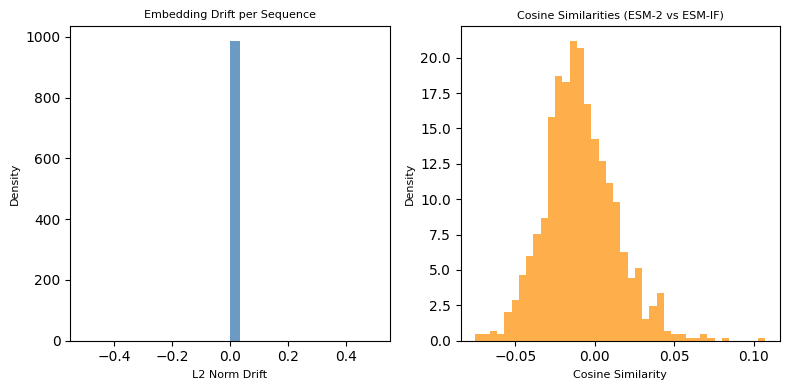

Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.32it/s]


[TEST] avg cos: 0.0022, std: 0.0270


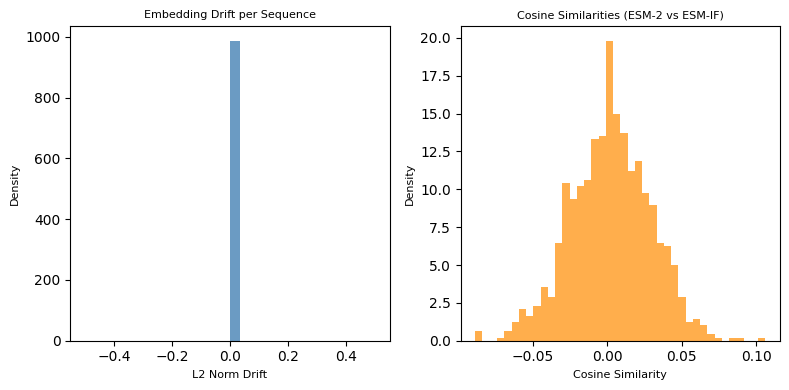

Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:39<00:00,  1.80it/s]


Epoch 1: loss=1.8074


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.92it/s]


[VAL]  avg cos: 0.0744, std: 0.0260


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.1065, std: 0.0523


Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:41<00:00,  1.79it/s]


Epoch 2: loss=1.0376


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.91it/s]


[VAL]  avg cos: 0.1882, std: 0.0434


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2069, std: 0.0583
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_encoder_2.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_down_2.pt


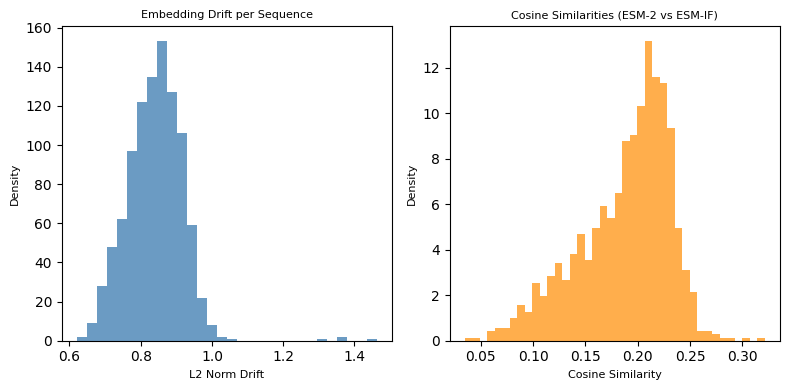


Freezing projection head (seq_down) after 1 epoch, continuing training of the rest...


Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:41<00:00,  1.78it/s]


Epoch 3: loss=0.8179


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.91it/s]


[VAL]  avg cos: 0.1905, std: 0.0437


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2089, std: 0.0587


Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:41<00:00,  1.78it/s]


Epoch 4: loss=0.7964


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.86it/s]


[VAL]  avg cos: 0.1934, std: 0.0443


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2111, std: 0.0591
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_encoder_4.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_down_4.pt


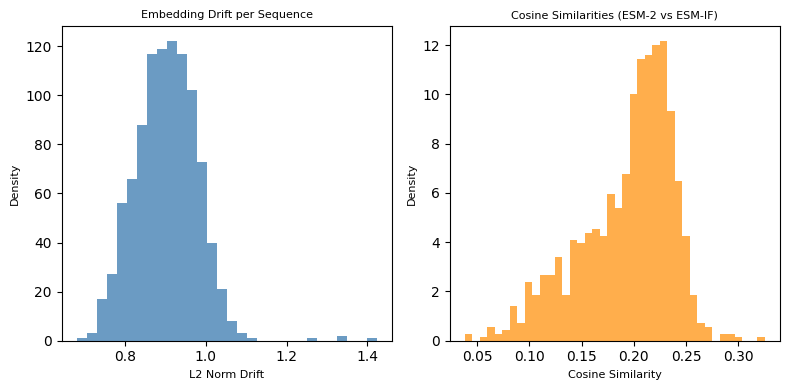

Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:42<00:00,  1.78it/s]


Epoch 5: loss=0.7671


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.92it/s]


[VAL]  avg cos: 0.1969, std: 0.0452


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2139, std: 0.0595


Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:40<00:00,  1.79it/s]


Epoch 6: loss=0.7454


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.90it/s]


[VAL]  avg cos: 0.2015, std: 0.0462


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2178, std: 0.0598
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_encoder_6.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_down_6.pt


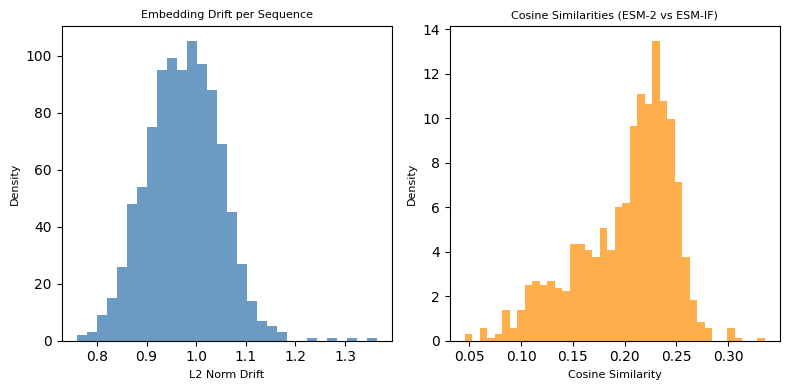

Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:41<00:00,  1.78it/s]


Epoch 7: loss=0.7193


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.89it/s]


[VAL]  avg cos: 0.2075, std: 0.0471


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2220, std: 0.0601


Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:41<00:00,  1.78it/s]


Epoch 8: loss=0.7175


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.88it/s]


[VAL]  avg cos: 0.2140, std: 0.0481


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2273, std: 0.0602
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_encoder_8.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_down_8.pt


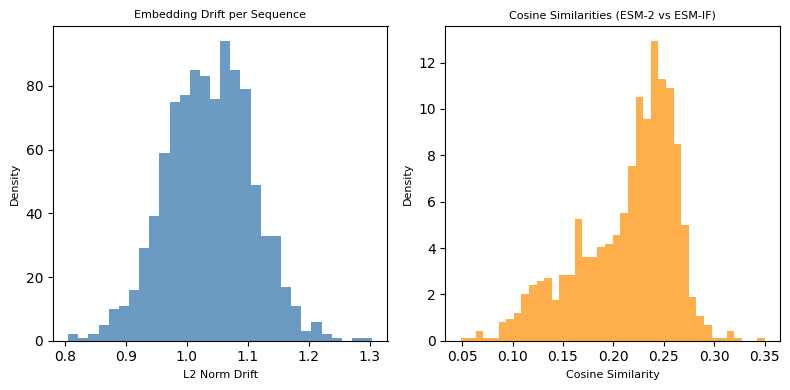

Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:41<00:00,  1.78it/s]


Epoch 9: loss=0.6769


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.86it/s]


[VAL]  avg cos: 0.2207, std: 0.0489


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2323, std: 0.0602


Running through epoch: 100%|████████████████████████████████████████████████████████████████| 395/395 [03:39<00:00,  1.80it/s]


Epoch 10: loss=0.6561


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.91it/s]


[VAL]  avg cos: 0.2278, std: 0.0495


Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]


[TEST] avg cos: 0.2377, std: 0.0603
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_encoder_10.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_down_10.pt


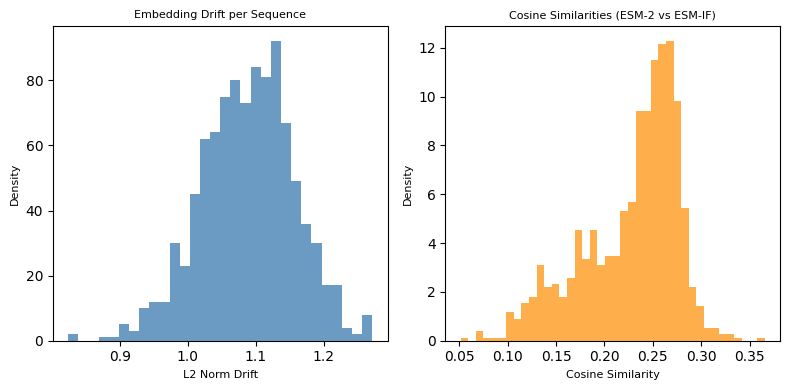


Extracting END embeddings & cosine similarities (val + test)...


Computing cosine similarity & embeddings (val): 100%|█████████████████████████████████████████| 99/99 [00:14<00:00,  6.85it/s]


[VAL]  avg cos: 0.2278, std: 0.0495


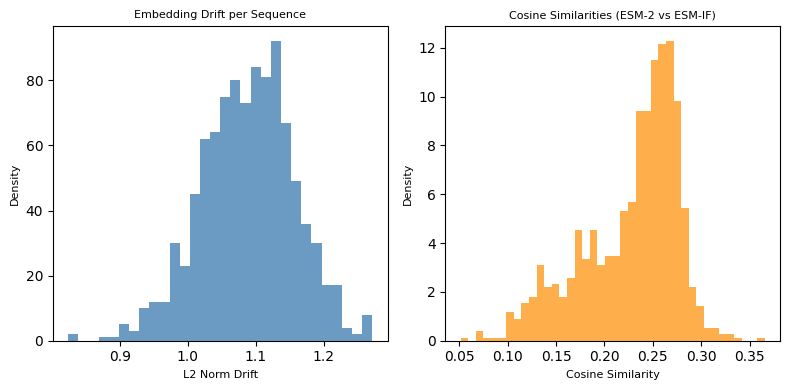

Computing cosine similarity & embeddings (test): 100%|████████████████████████████████████████| 99/99 [00:42<00:00,  2.31it/s]

[TEST] avg cos: 0.2377, std: 0.0603


In [20]:
# accelerator
model, optimizer, train_dataloader, test_dataloader, val_dataloader = accelerator.prepare(model, optimizer, train_dataloader, test_dataloader, val_dataloader)

training_wrapper = TrainWrapper(
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device
)

val_params, test_params = training_wrapper.train_model(save_every=2)

In [23]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.seq_len = self.dframe["seq_len"].max()

        # index & storage
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):

            # laod embeddings
            if accession.startswith("t_"):
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"
               
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))
                emb_seq = np.load(os.path.join(esm2_path, f"{accession[2:]}.npy"))
                sequence = str(self.dframe.loc[accession].sequence)

            else:
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"

                emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))
                emb_seq = np.load(os.path.join(esm2_path, f"{accession}.npy"))
                sequence = str(self.dframe.loc[accession].sequence)

            # quich check whether embedding dimmension is as it suppose to be
            if emb_seq.shape[1] != self.embedding_dim_seq:
                raise ValueError("Embedding dim mismatch with 'embedding_dim_seq'.")
            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")
                
            # add -5000 to all the padded target rows
            if emb_seq.shape[0] < self.seq_len:
                emb_seq = np.concatenate([emb_seq, np.full((self.seq_len - emb_seq.shape[0], emb_seq.shape[1]), self.emb_pad, dtype=emb_seq.dtype)], axis=0)
            else:
                emb_seq = emb_seq[: self.seq_len] # no padding was usedd

            if emb_struct.shape[0] < self.seq_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.seq_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.seq_len] # no padding was used

            self.samples.append((emb_seq, sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        emb_seq, seq, emb_struct = self.samples[idx]
        emb_seq, emb_struct = torch.from_numpy(emb_seq).float(), torch.from_numpy(emb_struct).float()
        # label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return emb_seq, seq, emb_struct

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        emb_seq_list, seqs_list, emb_struct_list = zip(*out)
    
        # Stack embeddings
        emb_seq_stacked  = torch.stack([torch.as_tensor(x) for x in emb_seq_list],  dim=0)  # [B, ...]        
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        # labels = torch.stack(lbl_list)  # [B]
    
        return emb_seq_stacked, seqs_list, emb_struct_stacked

emb_seq_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
emb_struct_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

meta_Dataset = CLIP_PPint_w_esmIF(
    meta_df_shuffled_LONG,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████████| 3548/3548 [00:26<00:00, 133.89it/s]


#### Stop after epoch 1

In [22]:
### Training seq_down for 1 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/5d521d76-3082-4258-99ba-0255033e8f16/ESM2EncoderLoRA_epoch_10.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/5d521d76-3082-4258-99ba-0255033e8f16/ProjHead_epoch_10.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

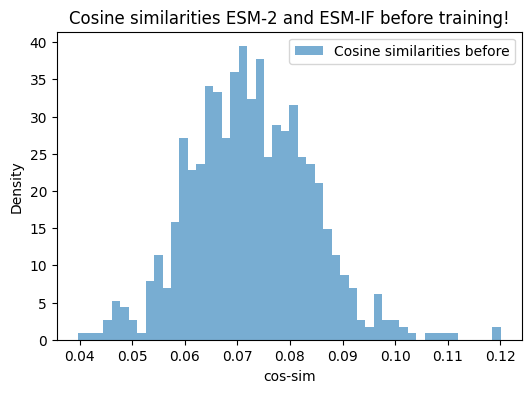

In [26]:
### Similarity using original embeddings and trained projection head
_loader = DataLoader(meta_Dataset, batch_size=5)
cosine_similarities_BEFORE = []
seq_proj = nn.Linear(1280, 512)

for batch in _loader:
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    # seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    seq_pooled_proj = seq_down(seq_pooled)
    # seq_pooled_proj = seq_proj(seq_pooled)

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

    seq_full = F.normalize(seq_pooled_proj, dim=-1)
    struct_full = F.normalize(struct_pooled, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_BEFORE.append(cos.mean().item())

plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_BEFORE, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

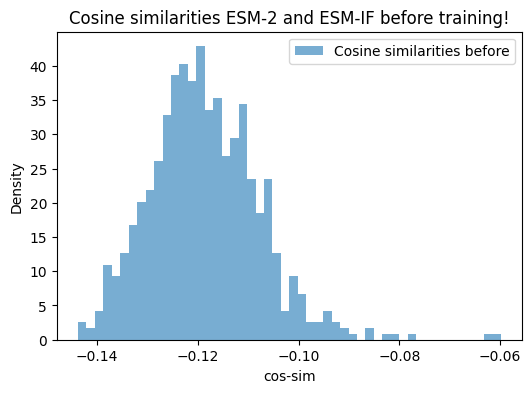

In [25]:
### Similarity using original embeddings and random nn.Linear(1280, 512) head

_loader = DataLoader(meta_Dataset, batch_size=5)
cosine_similarities_BEFORE = []
seq_proj = nn.Linear(1280, 512).to(device)

for batch in _loader:
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    # seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    # seq_pooled_proj = seq_down(seq_pooled)
    seq_pooled_proj = seq_proj(seq_pooled)

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

    seq_full = F.normalize(seq_pooled_proj, dim=-1)
    struct_full = F.normalize(struct_pooled, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_BEFORE.append(cos.mean().item())

plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_BEFORE, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

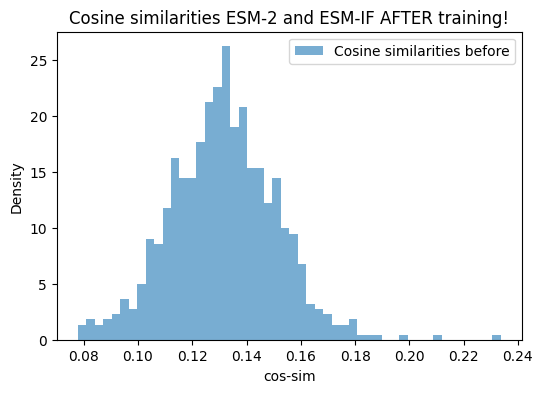

In [27]:
### Similarity using both trained seq_encoder + trained proj_head
_loader = DataLoader(meta_Dataset, batch_size=5)
cosine_similarities_AFTER = []

for batch in _loader:
    __, seqs_list, struct_embed = batch
    __, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    seq_embed = seq_encoder(seqs_list)  # [B, L, 1280]
    
    # seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    seq_pooled_proj = seq_down(seq_pooled)

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

    seq_full = F.normalize(seq_pooled_proj, dim=-1)
    struct_full = F.normalize(struct_pooled, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_AFTER.append(cos.mean().item())

plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_AFTER, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF AFTER training!")
plt.legend()
plt.show()

#### Stop after epohs 2

In [21]:
### Training seq_down for 2 epochs 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_encoder_10.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/80599b33-d6bd-464a-819f-41a1758742dc/seq_down_10.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

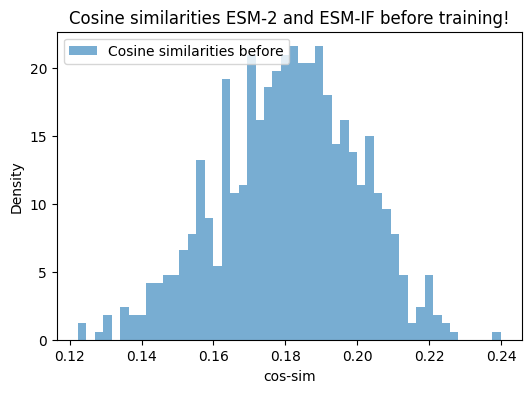

In [24]:
### Similarity using original embeddings and trained projection head
_loader = DataLoader(meta_Dataset, batch_size=5)
cosine_similarities_BEFORE = []
seq_proj = nn.Linear(1280, 512)

for batch in _loader:
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    # seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    seq_pooled_proj = seq_down(seq_pooled)
    # seq_pooled_proj = seq_proj(seq_pooled)

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

    seq_full = F.normalize(seq_pooled_proj, dim=-1)
    struct_full = F.normalize(struct_pooled, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_BEFORE.append(cos.mean().item())

plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_BEFORE, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

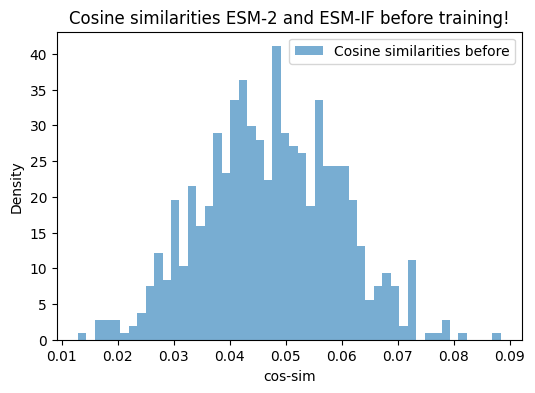

In [25]:
### Similarity using original embeddings and random nn.Linear(1280, 512) head

_loader = DataLoader(meta_Dataset, batch_size=5)
cosine_similarities_BEFORE = []
seq_proj = nn.Linear(1280, 512).to(device)

for batch in _loader:
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    # seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    # seq_pooled_proj = seq_down(seq_pooled)
    seq_pooled_proj = seq_proj(seq_pooled)

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

    seq_full = F.normalize(seq_pooled_proj, dim=-1)
    struct_full = F.normalize(struct_pooled, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_BEFORE.append(cos.mean().item())

plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_BEFORE, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

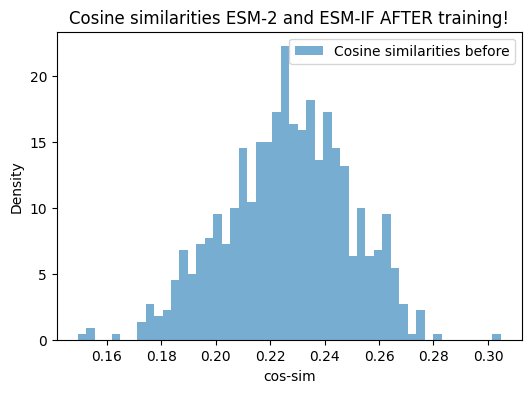

In [26]:
### Similarity using both trained seq_encoder + trained proj_head
_loader = DataLoader(meta_Dataset, batch_size=5)
cosine_similarities_AFTER = []

for batch in _loader:
    __, seqs_list, struct_embed = batch
    __, struct_embed = seq_embed.to(device), struct_embed.to(device)
    
    seq_embed = seq_encoder(seqs_list)  # [B, L, 1280]
    
    # seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
    seq_mask = create_key_padding_mask(seq_embed)
    seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
    seq_pooled_proj = seq_down(seq_pooled)

    struct_mask = create_key_padding_mask(struct_embed)
    struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

    seq_full = F.normalize(seq_pooled_proj, dim=-1)
    struct_full = F.normalize(struct_pooled, dim=-1)

    cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]
    cosine_similarities_AFTER.append(cos.mean().item())

plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_AFTER, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF AFTER training!")
plt.legend()
plt.show()

### Contrastive Sequence-Structure Pre-training (CSSP) - 2

Different learning rates for `seq_encoder` and `seq_down`

In [ ]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [ ]:
class CSSPBoostingESM(nn.Module):
    def __init__(self, seq_embed_dim=1280, struct_embed_dim=512, padding_value=-5000):
        super().__init__()
        self.padding_value = padding_value
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(seq_embed_dim, struct_embed_dim)

        # for p in self.struct_up.parameters():
        #     p.requires_grad = False
            
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward(self, sequences, struct_embed):
        
        seq_embed = self.seq_encoder(sequences)  # [B, L, 1280]
        seq_mask = create_key_padding_mask(seq_embed, self.padding_value)
        seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)          # [B, 1280]
        seq_pooled_proj = self.seq_down(seq_pooled)                          # [B, 512]
    
        struct_mask = create_key_padding_mask(struct_embed, self.padding_value)
        struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask) # [B, 512]
    
        seq_full = F.normalize(seq_pooled_proj, dim=-1)
        struct_full = F.normalize(struct_pooled, dim=-1)
    
        scale = torch.exp(self.logit_scale).clamp(max=100)
        logits_seq    = scale * (seq_full @ struct_full.T)   # [B, B]
        logits_struct = scale * (struct_full @ seq_full.T)   # [B, B]
    
        return logits_seq, logits_struct, seq_pooled_proj, struct_pooled, struct_mask

    def training_step(self, batch, device):
        sequences, struct_embed, _ = batch
        struct_embed = struct_embed.to(device)
        logits_seq, logits_struct, seq_pooled_proj, struct_pooled, struct_mask = self.forward(sequences, struct_embed)

        B = logits_seq.shape[0]
        labels = torch.arange(B, device=device)

        loss_seq    = F.cross_entropy(logits_seq, labels)
        loss_struct = F.cross_entropy(logits_struct, labels)
        clip_loss = (loss_seq + loss_struct) / 2

        return clip_loss 

In [ ]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    padding_value=-5000,
).to(device)

# model

runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 10
# batch_size = 3
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512).to("cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=learning_rate)
accelerator = Accelerator()
device = accelerator.device

train_dataloader = DataLoader(train_Dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_Dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(meta_Dataset, batch_size=10, shuffle=False)

In [ ]:
"""
- cos-similarity calculated per sequence
- train seq_down for 2 epochs and then freeze all parameters
"""

class TrainWrapper():

    def __init__(
        self,
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        val_loader=val_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    ):
        self.model = model
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.validation_loader = val_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device


    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.training_loader)
    

    @torch.no_grad()
    def compute_embeddings_cos_similariy(self, loader=None, loader_name="test"):

        if loader is None:
            loader = self.testing_loader

        self.model.eval()
        self.model.seq_encoder.eval()

        all_embeds = []
        cosine_similarities = []

        for batch in tqdm(loader, desc=f"Computing cosine similarity & embeddings ({loader_name})"):

            seqs, struct_embed, _ = batch
            struct_embed = struct_embed.to(self.device)

            # ---- sequence embeddings ----
            seq_embed = self.model.seq_encoder(seqs)  # [B, L, 1280]
            seq_mask = create_key_padding_mask(seq_embed)  # NOTE: only correct if seq_embed padding uses -5000
            seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)  # [B, 1280]
            seq_pooled_proj = self.model.seq_down(seq_pooled)

            # ---- structure embeddings ----
            struct_mask = create_key_padding_mask(struct_embed)
            struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)  # [B, 512]

            # ---- cosine similarity in CLIP space (per sequence) ----
            seq_full = F.normalize(seq_pooled_proj, dim=-1)
            struct_full = F.normalize(struct_pooled, dim=-1)

            cos = F.cosine_similarity(seq_full, struct_full, dim=-1)  # [B]

            cosine_similarities.extend(cos.cpu().tolist())
            all_embeds.extend(seq_full.detach().cpu())

        all_embeds = torch.stack(all_embeds)
        avg_cos = float(np.mean(cosine_similarities))
        std_cos = float(np.std(cosine_similarities))

        return all_embeds, cosine_similarities, avg_cos, std_cos


    def plot_embeddings_drift_cos_similarity_change(self, start_embeddings, end_embeddings, cosine_similarities):

        drift = (end_embeddings - start_embeddings).norm(dim=1).cpu().numpy()
        cosine_similarities = np.array(cosine_similarities)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].hist(drift, bins=30, color="steelblue", alpha=0.8)
        ax[0].set_title("Embedding Drift per Sequence", fontsize=8)
        ax[0].set_xlabel("L2 Norm Drift", fontsize=8)
        ax[0].set_ylabel("Density", fontsize=8)

        ax[1].hist(cosine_similarities, bins=40, color="darkorange", alpha=0.7, density=True)
        ax[1].set_title("Cosine Similarities (ESM-2 vs ESM-IF)", fontsize=8)
        ax[1].set_xlabel("Cosine Similarity", fontsize=8)
        ax[1].set_ylabel("Density", fontsize=8)

        plt.tight_layout()
        plt.show()


    def train_model(self, save_every: int = 5):

        run_dir = f"/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/{runID}/"
        os.makedirs(run_dir, exist_ok=True)

        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)

        # ---- Save checkpoint BEFORE training (epoch 0) ----
        save_path_encoder = os.path.join(run_dir, "ESM2EncoderLoRA_epoch_0.pt")
        save_path_projhead = os.path.join(run_dir, "ProjHead_epoch_0.pt")
        torch.save(self.model.seq_encoder.state_dict(), save_path_encoder)
        torch.save(self.model.seq_down.state_dict(), save_path_projhead)
        print(f"Saved seq_encoder checkpoint before training -> {save_path_encoder}")
        print(f"Saved proj head checkpoint before training -> {save_path_projhead}")

        # ---- START embeddings/cos-sim for both loaders ----
        print("\nExtracting START embeddings & cosine similarities (val + test)...")
        start_val_emb, start_val_cos, start_val_avg, start_val_std = self.compute_embeddings_cos_similariy(
            loader=self.validation_loader, loader_name="val"
        )
        print(f"[VAL]  avg cos: {start_val_avg:.4f}, std: {start_val_std:.4f}")

        start_test_emb, start_test_cos, start_test_avg, start_test_std = self.compute_embeddings_cos_similariy(
            loader=self.testing_loader, loader_name="test"
        )
        print(f"[TEST] avg cos: {start_test_avg:.4f}, std: {start_test_std:.4f}")

        # ---- Train ONLY 2 epochs (seq_down trainable), then freeze everything and STOP ----
        max_train_epochs = min(self.EPOCHS, 2)

        for epoch in range(1, max_train_epochs + 1):

            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")

            # ---- optional checkpoints ----
            if epoch % save_every == 0:
                save_path_encoder = os.path.join(run_dir, f"ESM2EncoderLoRA_epoch_{epoch}.pt")
                save_path_projhead = os.path.join(run_dir, f"ProjHead_epoch_{epoch}.pt")
                torch.save(self.model.seq_encoder.state_dict(), save_path_encoder)
                torch.save(self.model.seq_down.state_dict(), save_path_projhead)
                print(f"Saved seq_encoder checkpoint -> {save_path_encoder}")
                print(f"Saved proj head checkpoint -> {save_path_projhead}")

        # ---- Freeze ALL parameters after 2 epochs (full stop) ----
        print("\nFreezing ALL model parameters after 2 epochs (full stop)...")
        for p in self.model.parameters():
            p.requires_grad = False

        # ---- END embeddings/cos-sim for both loaders ----
        print("\nExtracting END embeddings & cosine similarities (val + test)...")
        end_val_emb, end_val_cos, end_val_avg, end_val_std = self.compute_embeddings_cos_similariy(
            loader=self.validation_loader, loader_name="val"
        )
        print(f"[VAL]  avg cos: {end_val_avg:.4f}, std: {end_val_std:.4f}")

        end_test_emb, end_test_cos, end_test_avg, end_test_std = self.compute_embeddings_cos_similariy(
            loader=self.testing_loader, loader_name="test"
        )
        print(f"[TEST] avg cos: {end_test_avg:.4f}, std: {end_test_std:.4f}")

        # Optional plots (val + test)
        # self.plot_embeddings_drift_cos_similarity_change(start_val_emb, end_val_emb, end_val_cos)
        # self.plot_embeddings_drift_cos_similarity_change(start_test_emb, end_test_emb, end_test_cos)

        return {
            "val":  (start_val_emb,  end_val_emb,  end_val_cos),
            "test": (start_test_emb, end_test_emb, end_test_cos),
        }

In [ ]:
# accelerator
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

training_wrapper = TrainWrapper(
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
)

val_params, test_params = training_wrapper.train_model(save_every=2)

#### Some testing

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=16,
            lora_alpha=128,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

$\cos(\theta) = \frac{a \cdot b}{\|a\| \, \|b\|}$

`numpy.linalg.norm` computes the vector norm, usually the Euclidean norm also called the $L2$ norm.

For vector $x = (x_1, x_2, ..., x_n)$: 

${\|x\|} = \sqrt{{x_1}^2 + {x_2}^2 + ... + {x_n}^2}$

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# _loader = DataLoader(test_Dataset, batch_size=5)
# proj = nn.Linear(1280, 512).to(device)
# encoder_ = ESM2EncoderLoRA().eval().to(device)
# # encoder_

In [ ]:
cosine_similarities = []

for batch in tqdm(_loader, total=len(_loader)):
    seqs, structs_emeb, lbls = batch
    seqs_emeb = encoder_(seqs)
    seqs_emeb_proj = proj(seqs_emeb.to(device))          # shape: [B, L, 512]

    # Create masks (must match projected embeddings)
    seq_mask = create_key_padding_mask(seqs_emeb_proj)
    struct_mask = create_key_padding_mask(structs_emeb)

    # Mean-pool (returns shape: [B, 512])
    vectors_seq = create_mean_of_non_masked(seqs_emeb_proj, seq_mask).cpu().detach().numpy()
    vectors_struct = create_mean_of_non_masked(structs_emeb, struct_mask).cpu().detach().numpy()

    # Loop through batch items
    for i in range(vectors_seq.shape[0]):
        cosine = np.dot(vectors_seq[i], vectors_struct[i]) / (norm(vectors_seq[i]) * norm(vectors_struct[i]))
        cosine_similarities.append(cosine)

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

In [ ]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

#### ESM2 encoder

In [ ]:
# class ESM2EncoderOriginal(nn.Module):
#     def __init__(self, padding_value=-5000.0):
#         super().__init__()

#         self.padding_value = padding_value

#         self.model = EsmModel.from_pretrained(
#             "facebook/esm2_t33_650M_UR50D",
#             output_hidden_states=True
#         )
#         self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

#     @torch.no_grad()
#     def get_attentions(self, sequences):
#         inputs = self.tokenizer(
#             sequences, return_tensors="pt", padding=True
#         ).to(self.model.device)

#         out = self.model(**inputs, output_attentions=True)
#         return out.attentions   # list[num_layers] → [B, num_heads, L, L]

#     def forward(self, sequences):
#         inputs = self.tokenizer(
#             sequences, return_tensors="pt", padding=True
#         ).to(self.model.device)

#         out = self.model(**inputs)
#         reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
#         reps = reps[:, 1:-1, :]                       # remove CLS/EOS

#         seq_lengths = [len(s) for s in sequences]
#         Lmax = max(seq_lengths)

#         B, D = reps.size(0), reps.size(-1)
#         padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

#         for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
#             padded[i, :real_len] = r[:real_len]

#         return padded

In [ ]:
# sequences = []
# for i, row in Df_test_LONG.iterrows():
#     seq_name = f"prot_{i}"
#     sequence = str(row.sequence)
#     entry = (seq_name, sequence)
#     sequences.append(entry)
# sequences[:5]

# # Embedings original seqeunces
# encoder = ESM2EncoderOriginal().to("cuda")   # create model
# embeds = encoder(seq)

# print(embeds.shape)

# # Mean pooling
# seq_mask_emb = create_key_padding_mask(embeddings = embeds, padding_value = -5000.0).to(device)
# seq_embed_pooled_START = create_mean_of_non_masked(embeds, seq_mask_emb)
# seq_embed_pooled_START

### ESM encoder with LoRA added

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [ ]:
# encoder = ESM2EncoderLoRA()
# encoder = encoder.eval()
# sequences = ["MKTAGALA","GAY"]
# padded, mask = encoder(sequences)
# print(padded.shape)
# seq_mask_emb = create_key_padding_mask(embeddings = padded, padding_value = -5000.0).to(device)
# seq_embed_pooled_START = create_mean_of_non_masked(padded, seq_mask_emb)
# print(seq_embed_pooled_START)
# print(padded)

In [ ]:
# # Embedings original seqeunces
# sequences = [
#     ("seq1", "MKTAGALA"),
#     ("seq2", "GAY")
# ]
# encoder = ESM2EncoderOriginal()   # create model
# encoder = encoder.eval()
# embeds = encoder(sequences)

# # Mean pooling
# seq_mask_emb = create_key_padding_mask(embeddings = embeds, padding_value = -5000.0)
# seq_embed_pooled_START = create_mean_of_non_masked(embeds, seq_mask_emb)
# seq_embed_pooled_START
# print(embeds)

### CSSPBoostingESM model - 1

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [ ]:
class CSSPBoostingESM(nn.Module):
    def __init__(
        self,
        seq_embed_dim=1280,
        struct_embed_dim=512,
        padding_value=-5000,
        num_heads=8,
        num_recycles=2
    ):
        super().__init__()

        self.seq_embed_dim = seq_embed_dim
        self.struct_embed_dim = struct_embed_dim
        self.padding_value = padding_value
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

        # ESM2 encoder
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(self.seq_embed_dim, self.struct_embed_dim)

    def forward(self, sequences, struct_embed):
        
        seq_embed = self.seq_encoder(sequences)        # [B, Ls, 1280]
        seq_embed_proj = self.seq_down(seq_embed)          # [B, Ls, 512]

        ### pooling
        seq_mask = create_key_padding_mask(seq_embed_proj, self.padding_value)
        struct_mask = create_key_padding_mask(struct_embed, self.padding_value)
        
        seq_pooled = create_mean_of_non_masked(seq_embed_proj, seq_mask)      
        struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)
        
        seq_full = F.normalize(seq_pooled, dim=-1)
        struct_full = F.normalize(struct_pooled, dim=-1)
        
        scale = torch.exp(self.logit_scale).clamp(max=100)
    
        logits_seq = scale * seq_full @ struct_full.T     # seq → struct
        logits_struct = scale * struct_full @ seq_full.T  # struct → seq

        # cos_loss = 1 - F.cosine_similarity(seq_full, struct_full).mean()
    
        return logits_seq, logits_struct

    def training_step(self, batch, device):
        sequences, struct_embed, labels = batch
        
        logits_seq, logits_struct = self.forward(sequences, struct_embed.to(device))
        
        B = len(sequences)

        labels = torch.arange(B, device=logits_seq.device)
        
        loss_seq = F.cross_entropy(logits_seq, labels)
        loss_struct = F.cross_entropy(logits_struct, labels)
        
        loss = (loss_seq + loss_struct) / 2

        return loss

    def validation_step_PPint(self, batch, device):

        sequences, struct_embed, labels = batch
        struct_embed = struct_embed.to(device)
        
        with torch.no_grad():

            B = len(sequences)
    
            positive_logits = self.forward(sequences, struct_embed)
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))

            rows, cols = torch.triu_indices(B, B, offset=1)
            sequences_list  = [sequences[i] for i in rows.tolist()]  # list of [Li, 256]

            negative_logits = self.forward(sequences_list, struct_embed[cols, :, :])
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
                        
            loss = (positive_loss + negative_loss) / 2
            
            logit_matrix = torch.zeros((B, B), device=device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            diag_indices = torch.arange(B, device=device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(B).to(device)
            accuracy = peptide_predictions.eq(labels).float().mean()
    
            return loss, accuracy

    def validation_step_MetaDataset(self, batch, device):
        sequences, struct_embed, labels = batch
        struct_embed, labels = struct_embed.to(device), labels.float().to(device)
        
        with torch.no_grad():
            
            logits = self.forward(sequences, struct_embed).float()
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            
            return logits, loss

    def calculate_logit_matrix(self, sequences, struct_embed):
        
        B = len(sequences)
        rows, cols = torch.triu_indices(B, B, offset=1)
        
        positive_logits = self.forward(sequences, struct_embed)
        
        sequences_list  = [sequences[i] for i in rows.tolist()] 
        negative_logits = self.forward(sequences[rows,:,:], struct_embed[cols,:,:])
        
        logit_matrix = torch.zeros((B, B), device=sequences.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(B, device=sequences.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [ ]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    num_recycles=2
).to("cuda")

# model

runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 15
# batch_size = 3
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512, num_recycles=2).to("cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=learning_rate)
accelerator = Accelerator()
device = accelerator.device

train_dataloader = DataLoader(train_Dataset, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_Dataset, batch_size=5, shuffle=False)

In [ ]:
class TrainWrapper():

    def __init__(
        self,
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    ):
        self.model = model
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device

        # projection used for diagnostics
        self.proj = nn.Linear(1280, 512).to(self.device)

    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.training_loader)

    @torch.no_grad()
    def compute_embeddings_cos_similariy(self):

        self.model.eval()
        self.model.seq_encoder.eval()

        all_embeds = []
        cosine_similarities = []

        for batch in tqdm(self.testing_loader, desc="Computing cosine similarity & embeddings"):

            seqs, struct_embed , __ = batch
            seq_embed = self.model.seq_encoder(seqs)
            seq_embed_proj = self.model.seq_down(seq_embed)
            
            struct_embed = struct_embed.to(self.device)
            struct_mask = (struct_embed != -5000).any(dim=-1)
            
            for i in range(struct_mask.shape[0]):
                true_len = struct_mask[i].sum()
                seq_i = seq_embed_proj[i, :true_len, :]            # [L_true, D]
                struct_i = struct_embed[i, :true_len, :]        # [L_true, D]
                
                cos = F.cosine_similarity(seq_i, struct_i, dim=-1)   # [L_true]
                cosine_similarities.append(cos.mean().item())
    
                # pool seq embedding
                pooled_embed = seq_i.mean(dim=0).cpu()
                all_embeds.append(pooled_embed)
    
        all_embeds = torch.stack(all_embeds)
        avg_cos = np.mean(cosine_similarities)
        std_cos = np.std(cosine_similarities)
    
        return all_embeds, cosine_similarities, float(avg_cos), float(std_cos)

    def plot_embeddings_drift_cos_similarity_change(self, start_embeddings, end_embeddings, cosine_similarities):

        drift = (end_embeddings - start_embeddings).norm(dim=1).cpu().numpy()
        cosine_similarities = np.array(cosine_similarities)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Drift subplot
        ax[0].hist(drift, bins=30, color="steelblue", alpha=0.8)
        ax[0].set_title("Embedding Drift per Sequence", fontsize=8)
        ax[0].set_xlabel("L2 Norm Drift", fontsize=8)
        ax[0].set_ylabel("Density", fontsize=8)

        # Cosine similarity subplot
        ax[1].hist(cosine_similarities, bins=40, color="darkorange", alpha=0.7, density=True)
        ax[1].set_title("Cosine Similarities (ESM-2 vs ESM-IF)", fontsize=8)
        ax[1].set_xlabel("Cosine Similarity", fontsize=8)
        ax[1].set_ylabel("Density", fontsize=8)

        plt.tight_layout()
        plt.show()

    def train_model(self):

        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)

        print("\nExtracting START sequence embeddings & cosine similarities...")
        start_embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()
        print(f"Average cos-similarity: {avg_cosine}, standard deviation: {std_cosine}")
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, start_embeddings, cosine_similarities)

        for epoch in range(1, self.EPOCHS + 1):
            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")

            embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()
            print(f"Average cos-similarity: {round(avg_cosine, 4)}, standard deviation: {round(std_cosine, 4)}")
            self.plot_embeddings_drift_cos_similarity_change(start_embeddings, embeddings, cosine_similarities)

        print("\nExtracting END sequence embeddings...")
        end_embeddings, end_cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy()

        return start_embeddings, end_embeddings, end_cosine_similarities

In [ ]:
# accelerator
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

training_wrapper = TrainWrapper(
            model=model,
            train_loader=train_dataloader,
            optimizer=optimizer,
            epochs=EPOCHS,
            device=device,
)
torch.cuda.empty_cache()
start_embeddings, end_embeddings, end_cosine_similarities = training_wrapper.train_model() # start training

### CSSPBoostingESM model - 2 

In [ ]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences, glb_max_len):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = glb_max_len

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [ ]:
class CSSPBoostingESM(nn.Module):
    def __init__(self, seq_embed_dim=1280, struct_embed_dim=512, padding_value=-5000):
        super().__init__()
        self.padding_value = padding_value
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(seq_embed_dim, struct_embed_dim)
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward(self, sequences, struct_embed, max_len: int):
        seq_embed = self.seq_encoder(sequences, max_len)
        seq_embed_proj = self.seq_down(seq_embed)

        seq_mask    = create_key_padding_mask(seq_embed_proj, self.padding_value)
        struct_mask = create_key_padding_mask(struct_embed,    self.padding_value)

        seq_pooled    = create_mean_of_non_masked(seq_embed_proj, seq_mask)
        struct_pooled = create_mean_of_non_masked(struct_embed,    struct_mask)

        seq_full = F.normalize(seq_pooled, dim=-1)
        struct_full = F.normalize(struct_pooled, dim=-1)

        scale = torch.exp(self.logit_scale).clamp(max=100)
        logits_seq    = scale * seq_full @ struct_full.T
        logits_struct = scale * struct_full @ seq_full.T

        return logits_seq, logits_struct, seq_embed_proj, struct_embed, struct_mask

    def training_step(self, batch, device, max_len: int):
        sequences, struct_embed, _ = batch
        struct_embed = struct_embed.to(device)

        logits_seq, logits_struct, seq_tok, struct_tok, struct_mask = self.forward(
            sequences, struct_embed, max_len=max_len
        )

        B = logits_seq.shape[0]
        labels = torch.arange(B, device=device)

        loss_seq    = F.cross_entropy(logits_seq, labels)
        loss_struct = F.cross_entropy(logits_struct, labels)
        clip_loss = (loss_seq + loss_struct) / 2

        mask = (~struct_mask).unsqueeze(-1)  # [B, L, 1]
        cos = F.cosine_similarity(seq_tok * mask, struct_tok * mask, dim=-1)
        per_token_loss = 1 - (cos.sum(dim=1) / mask.sum(dim=1).squeeze(-1)).mean()

        return clip_loss + 0.1 * per_token_loss

In [ ]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    padding_value=-5000,
).to(device)

# model

runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 10
# batch_size = 3
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512).to("cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=learning_rate)
accelerator = Accelerator()
device = accelerator.device

train_dataloader = DataLoader(train_Dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_Dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(meta_Dataset, batch_size=10, shuffle=False)

In [ ]:
class TrainWrapper():

    def __init__(
        self,
        len_test_max = 500,
        len_train_max = 500,
        len_val_max = 500,
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        val_loader=val_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    ):
        self.model = model
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.validation_loader = val_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device
        self.max_len_test = len_test_max
        self.max_len_train = len_train_max
        self.max_len_val = len_val_max

        # projection used for diagnostics
        self.proj = nn.Linear(1280, 512).to(self.device)

    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device, self.max_len_train)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.training_loader)

    @torch.no_grad()
    def compute_embeddings_cos_similariy(self, Data_loader, max_len):

        self.model.eval()
        self.model.seq_encoder.eval()

        all_embeds = []
        cosine_similarities = []

        for batch in tqdm(Data_loader, desc="Computing cosine similarity & embeddings"):

            seqs, struct_embed , __ = batch
            seq_embed = self.model.seq_encoder(seqs, max_len)
            seq_embed_proj = self.model.seq_down(seq_embed)
            
            struct_embed = struct_embed.to(self.device)
            struct_mask = (struct_embed != -5000).any(dim=-1)
            
            for i in range(struct_mask.shape[0]):
                true_len = struct_mask[i].sum()
                seq_i = seq_embed_proj[i, :true_len, :]            # [L_true, D]
                struct_i = struct_embed[i, :true_len, :]        # [L_true, D]
                
                cos = F.cosine_similarity(seq_i, struct_i, dim=-1)   # [L_true]
                cosine_similarities.append(cos.mean().item())
    
                # pool seq embedding
                pooled_embed = seq_i.mean(dim=0).cpu()
                all_embeds.append(pooled_embed)
    
        all_embeds = torch.stack(all_embeds)
        avg_cos = np.mean(cosine_similarities)
        std_cos = np.std(cosine_similarities)
    
        return all_embeds, cosine_similarities, float(avg_cos), float(std_cos)

    def plot_embeddings_drift_cos_similarity_change(self, start_embeddings, end_embeddings, cosine_similarities):

        drift = (end_embeddings - start_embeddings).norm(dim=1).cpu().numpy()
        cosine_similarities = np.array(cosine_similarities)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Drift subplot
        ax[0].hist(drift, bins=30, color="steelblue", alpha=0.8)
        ax[0].set_title("Embedding Drift per Sequence", fontsize=8)
        ax[0].set_xlabel("L2 Norm Drift", fontsize=8)
        ax[0].set_ylabel("Density", fontsize=8)

        # Cosine similarity subplot
        ax[1].hist(cosine_similarities, bins=40, color="darkorange", alpha=0.7, density=True)
        ax[1].set_title("Cosine Similarities (ESM-2 vs ESM-IF)", fontsize=8)
        ax[1].set_xlabel("Cosine Similarity", fontsize=8)
        ax[1].set_ylabel("Density", fontsize=8)

        plt.tight_layout()
        plt.show()

    def train_model(self, save_every: int = 5):

        # Base directory for this run
        run_dir = f"/work3/s232958/data/trained/boostingESM2wESMIF/PPint/{runID}/"
        os.makedirs(run_dir, exist_ok=True)

        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)

        # ---- Save checkpoint BEFORE training (epoch 0) ----
        save_path = os.path.join(run_dir, "ESM2boosted_epoch_0.pt")
        torch.save(self.model.seq_encoder.state_dict(), save_path)
        print(f"Saved seq_encoder checkpoint before training -> {save_path}")

        print("\nExtracting START sequence embeddings & cosine similarities...")
        start_embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy(self.testing_loader, self.max_len_test)
        print(f"Average cos-similarity Test-set: {avg_cosine}, standard deviation: {std_cosine}")
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, start_embeddings, cosine_similarities)

        start_embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy(self.validation_loader, self.max_val_test)
        print(f"Average cos-similarity Val-set: {avg_cosine}, standard deviation: {std_cosine}")
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, start_embeddings, cosine_similarities)

        for epoch in range(1, self.EPOCHS + 1):
            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")

            embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy(self.testing_loader, self.max_len_test)
            print(f"Average cos-similarity Test-set: {avg_cosine}, standard deviation: {std_cosine}")
            self.plot_embeddings_drift_cos_similarity_change(start_embeddings, embeddings, cosine_similarities)
    
            embeddings, cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy(self.val_dataloader, self.max_val_test)
            print(f"Average cos-similarity Val-set: {avg_cosine}, standard deviation: {std_cosine}")
            self.plot_embeddings_drift_cos_similarity_change(start_embeddings, embeddings, cosine_similarities)

            # ---- Save every `save_every` epochs ----
            if epoch % save_every == 0:
                save_path = os.path.join(run_dir, f"ESM2boosted_epoch_{epoch}.pt")
                torch.save(self.model.seq_encoder.state_dict(), save_path)
                print(f"Saved seq_encoder checkpoint at epoch {epoch} -> {save_path}")

        print("\nExtracting END sequence embeddings...")
        end_embeddings, end_cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy(self.testing_loader, self.max_len_test)
        print(f"Average cos-similarity Test-set: {avg_cosine}, standard deviation: {std_cosine}")
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, end_embeddings, cosine_similarities)

        end_embeddings, end_cosine_similarities, avg_cosine, std_cosine = self.compute_embeddings_cos_similariy(self.val_dataloader, self.max_val_test)
        print(f"Average cos-similarity Val-set: {avg_cosine}, standard deviation: {std_cosine}")
        self.plot_embeddings_drift_cos_similarity_change(start_embeddings, end_embeddings, cosine_similarities)
        
        return start_embeddings, end_embeddings, end_cosine_similarities

In [ ]:
# accelerator
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

training_wrapper = TrainWrapper(
    len_test_max = Df_test_LONG.seq_len.max(),
    len_train_max = Df_train_LONG.seq_len.max(),
    len_val_max = meta_sample_Df.seq_len.max(),
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
)

start_embeddings, end_embeddings, end_cosine_similarities = training_wrapper.train_model(save_every=5)

### Loading model and tetsing on meta-analysis

In [ ]:
checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/259f46f3-26bc-4d5b-b923-04af96da9fc9/ESM2boosted_epoch_50.pt"
state_dict = torch.load(checkpoint_path, map_location=device)

model = ESM2EncoderLoRA()
model.load_state_dict(state_dict)
model.to(device)
model.eval()  # or model.train()
# print("Loaded seq_encoder weights from:", checkpoint_path)

In [ ]:
meta_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_w_pbd_lens.csv").drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})

# Interaction Dict
meta_df_sample = meta_df.sample(frac=0.15, random_state=0).reset_index(drop=True)
meta_df_sample

In [ ]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.max_seq_len = self.dframe["seq_len_binder"].max()
        self.max_str_len = self.dframe["pdb_len_binder"].max()

        # paths
        self.seq_encodings_path, self.struct_encodings_path = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):

            # laod embeddings
            emb_seq = np.load(os.path.join(self.seq_encodings_path, f"{accession}.npy"))     # [Lt, D]
            emb_struct = np.load(os.path.join(self.struct_encodings_path, f"{accession}.npy"))     # [Lb, D]
            seq = str(self.dframe.loc[accession].binder_seq)

            # quich check whether embedding dimmension is as it suppose to be
            if emb_seq.shape[1] != self.embedding_dim_seq:
                raise ValueError("Embedding dim mismatch with 'embedding_dim_seq'.")
            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")
                
            # add -5000 to all the padded target rows
            if emb_seq.shape[0] < self.max_seq_len:
                emb_seq = np.concatenate([emb_seq, np.full((self.max_seq_len - emb_seq.shape[0], emb_seq.shape[1]), self.emb_pad, dtype=emb_seq.dtype)], axis=0)
            else:
                emb_seq = emb_seq[: self.max_seq_len] # no padding was usedd

            if emb_struct.shape[0] < self.max_str_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.max_str_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.max_str_len] # no padding was used

            self.samples.append((emb_seq, seq, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        emb_seq, seq, emb_struct = self.samples[idx]
        emb_seq, emb_struct = torch.from_numpy(emb_seq).float(), torch.from_numpy(emb_struct).float()
        # label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return emb_seq, seq, emb_struct

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        emb_seq_list, seqs_list, emb_struct_list = zip(*out)
    
        # Stack embeddings
        emb_seq_stacked  = torch.stack([torch.as_tensor(x) for x in emb_seq_list],  dim=0)  # [B, ...]        
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        # labels = torch.stack(lbl_list)  # [B]
    
        return emb_seq_stacked, seqs_list, emb_struct_stacked

emb_seq_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
emb_struct_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

meta_Dataset = CLIP_PPint_w_esmIF(
    meta_df_sample,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

In [ ]:
_loader = DataLoader(meta_Dataset, batch_size=10)
proj = nn.Linear(1280, 512).to(device)
cosine_similarities_BEFORE_per_token = []

for batch in _loader:
    seqs_emeb, seqs_list, structs_emeb = batch
    seqs_emeb, structs_emeb = seqs_emeb.to(device), structs_emeb.to(device)
    
    # Project both embeddings if they start at 1280 dim
    seq_embed_proj = proj(seqs_emeb)          # shape: [B, L, 512]

    struct_mask = (structs_emeb != -5000).any(dim=-1)

    for i in range(struct_mask.shape[0]):
        true_len = struct_mask[i].sum()
        seq_i = seq_embed_proj[i, :true_len, :]            # [L_true, D]
        struct_i = structs_emeb[i, :true_len, :]        # [L_true, D]
        
        cos = F.cosine_similarity(seq_i, struct_i, dim=-1)   # [L_true]
        cosine_similarities_BEFORE_per_token.append(cos.mean().item())

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_BEFORE_per_token, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

In [ ]:
cosine_similarities_BEFORE_pooled_per_seq = []

for batch in _loader:
    seqs_emeb, seqs_list, structs_emeb = batch
    seqs_emeb, structs_emeb = seqs_emeb.to(device), structs_emeb.to(device)
    
    # Project both embeddings if they start at 1280 dim
    seqs_emeb_proj = proj(seqs_emeb)          # shape: [B, L, 512]

    # Create masks (must match projected embeddings)
    seq_mask = create_key_padding_mask(seqs_emeb_proj)
    struct_mask = create_key_padding_mask(structs_emeb)

    # Mean-pool (returns shape: [B, 512])
    vectors_seq = create_mean_of_non_masked(seqs_emeb_proj, seq_mask).cpu().detach().numpy()
    vectors_struct = create_mean_of_non_masked(structs_emeb, struct_mask).cpu().detach().numpy()

    # Loop through batch items
    for i in range(vectors_seq.shape[0]):
        cosine = np.dot(vectors_seq[i], vectors_struct[i]) / (norm(vectors_seq[i]) * norm(vectors_struct[i]))
        cosine_similarities_BEFORE_pooled_per_seq.append(cosine)

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_BEFORE_pooled_per_seq, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

In [ ]:
cosine_similarities_AFTER_per_token = []

for batch in _loader:
    ___, seqs_list, structs_emeb = batch
    seqs_emeb = model(seqs_list, meta_df_sample.seq_len_binder.max())
    structs_emeb, seqs_emeb = structs_emeb.to(device), seqs_emeb.to(device)
    
    # Project both embeddings if they start at 1280 dim
    seq_embed_proj = proj(seqs_emeb)          # shape: [B, L, 512]

    struct_mask = (structs_emeb != -5000).any(dim=-1)

    for i in range(struct_mask.shape[0]):
        true_len = struct_mask[i].sum()
        seq_i = seq_embed_proj[i, :true_len, :]            # [L_true, D]
        struct_i = structs_emeb[i, :true_len, :]        # [L_true, D]
        
        cos = F.cosine_similarity(seq_i, struct_i, dim=-1)   # [L_true]
        cosine_similarities_AFTER_per_token.append(cos.mean().item())

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_AFTER_per_token, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF before training!")
plt.legend()
plt.show()

In [ ]:
cosine_similarities_AFTER_pooled_per_seq = []

for batch in _loader:
    ___, seqs_list, structs_emeb = batch
    
    # Project both embeddings if they start at 1280 dim
    seqs_emeb = model(seqs_list, meta_df_sample.seq_len_binder.max())
    structs_emeb, seqs_emeb = structs_emeb.to(device), seqs_emeb.to(device)
    seqs_emeb_proj = proj(seqs_emeb)          # shape: [B, L, 512]

    # Create masks (must match projected embeddings)
    seq_mask = create_key_padding_mask(seqs_emeb_proj)
    struct_mask = create_key_padding_mask(structs_emeb)

    # Mean-pool (returns shape: [B, 512])
    vectors_seq = create_mean_of_non_masked(seqs_emeb_proj, seq_mask).cpu().detach().numpy()
    vectors_struct = create_mean_of_non_masked(structs_emeb, struct_mask).cpu().detach().numpy()

    # Loop through batch items
    for i in range(vectors_seq.shape[0]):
        cosine = np.dot(vectors_seq[i], vectors_struct[i]) / (norm(vectors_seq[i]) * norm(vectors_struct[i]))
        cosine_similarities_AFTER_pooled_per_seq.append(cosine)

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(cosine_similarities_AFTER_pooled_per_seq, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities ESM-2 and ESM-IF AFTER training!")
plt.legend()
plt.show()